In [4]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys

sys.path.append("../")


import matplotlib.pyplot as plt  # noqa: E402
from matplotlib import rcParams  # noqa: E402
from matplotlib import font_manager  # noqa: E402
import pandas as pd  # noqa: E402


import scipy.constants as const  # noqa: E402


from src.WellClass.libs.well_pressure.Pressure import Pressure  # noqa: E402
from src.WellClass.libs.plotting import plot_pressure  # noqa: E402
from src.WellClass.libs.pvt.pvt import (  # noqa: E402
    load_pvt_data,
    get_mixture_info,
)

In [ ]:
# resource configuration
rcParams["figure.dpi"] = 200

# fount information
rcParams["font.family"] = "Equinor"
rcParams["font.size"] = 9

# font location
font_path = r"Equinor_regular"
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [ ]:
from pathlib import Path


pvt_path = Path(r"../src/WellClass/libs/pvt/pvt_constants")

co2_path_name = "pure_co2"

co2_path = pvt_path / co2_path_name


mixture_info = get_mixture_info(co2_path)

mixture_name = mixture_info["name"]
mixture_composition = mixture_info["composition"]

print(f"Computing pressures for {mixture_name} ({mixture_composition})")

Computing pressures for pure CO2 (100% CO2)


In [9]:
co2_pvt_data = load_pvt_data(pvt_root_path=pvt_path.as_posix(), fluid_type=co2_path_name)

In [10]:
co2_pvt_data.keys()

dict_keys(['temperature', 'pressure', 'brine', 'pure_co2'])

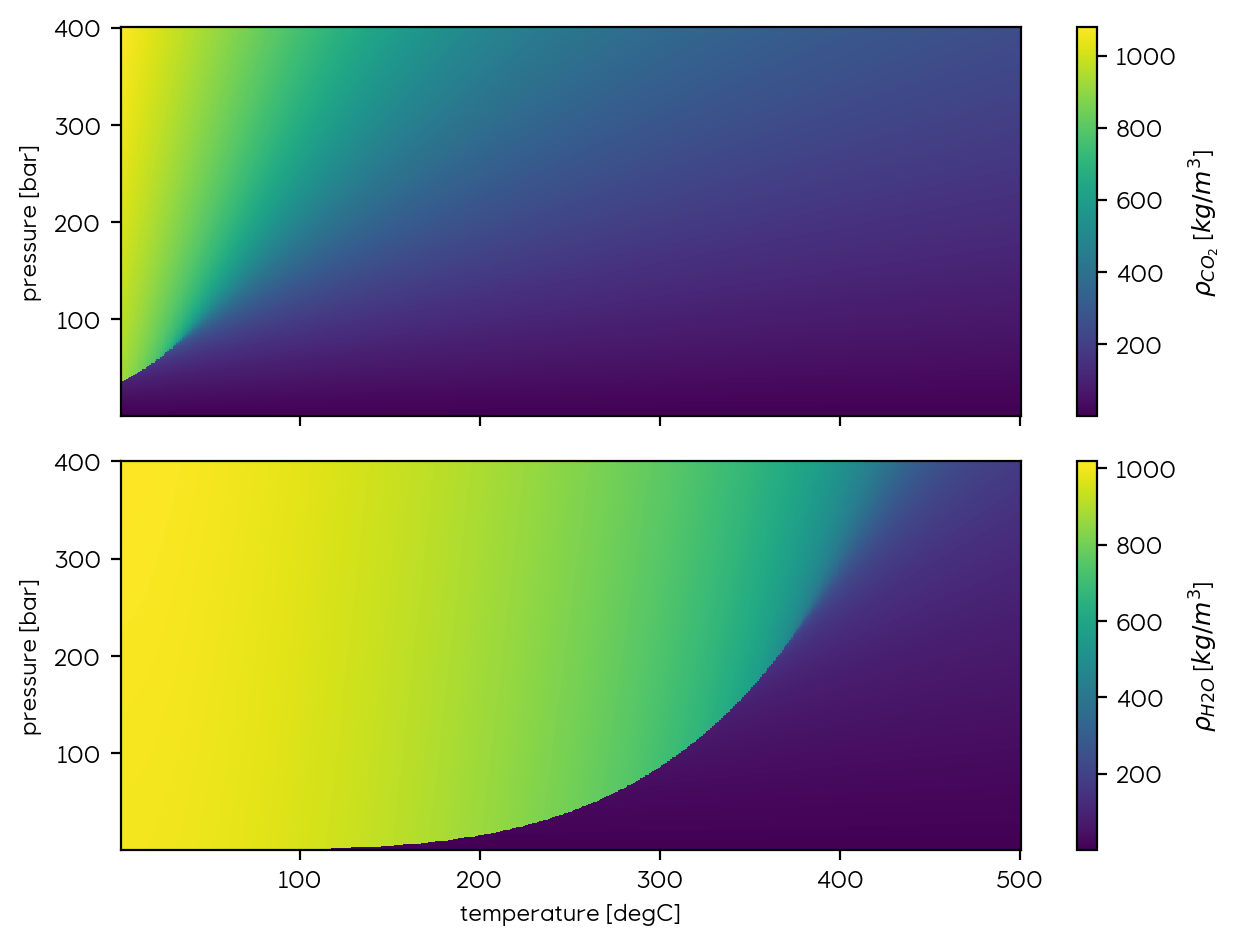

In [ ]:
# Plot tables
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# Plot density colormap
rho_pcm_co2 = ax1.pcolormesh(co2_pvt_data["temperature"], co2_pvt_data["pressure"], co2_pvt_data["pure_co2"]["rho"])
rho_pcm_h2o = ax2.pcolormesh(co2_pvt_data["temperature"], co2_pvt_data["pressure"], co2_pvt_data["brine"]["rho"])

ax2.set_xlabel("temperature [degC]")
ax1.set_ylabel("pressure [bar]")
ax2.set_ylabel("pressure [bar]")

fig.colorbar(rho_pcm_co2, label=r"$\rho_{CO_2}$ [$kg/m^3$]")

fig.colorbar(rho_pcm_h2o, label=r"$\rho_{H2O}$ [$kg/m^3$]")


fig.tight_layout()

## How to use the lookup tables for computing buoyancy pressure

In this example we compute the buoyancy pressure 200 meters above the CO2-water contact at 1500 mTVDMSL

1. We compute the hydrostatic gradient

In [ ]:
olga_pure_co2_122 = pd.read_excel(r"./olga_ref_runs/PureCO2.xlsx", sheet_name=0)
olga_pure_co2_94 = pd.read_excel(r"./olga_ref_runs/PureCO2.xlsx", sheet_name=1)
olga_pure_co2_75 = pd.read_excel(r"./olga_ref_runs/PureCO2.xlsx", sheet_name=2)
olga_pure_co2_47 = pd.read_excel(r"./olga_ref_runs/PureCO2.xlsx", sheet_name=3)


olga_tables = [olga_pure_co2_122, olga_pure_co2_94, olga_pure_co2_75, olga_pure_co2_47]

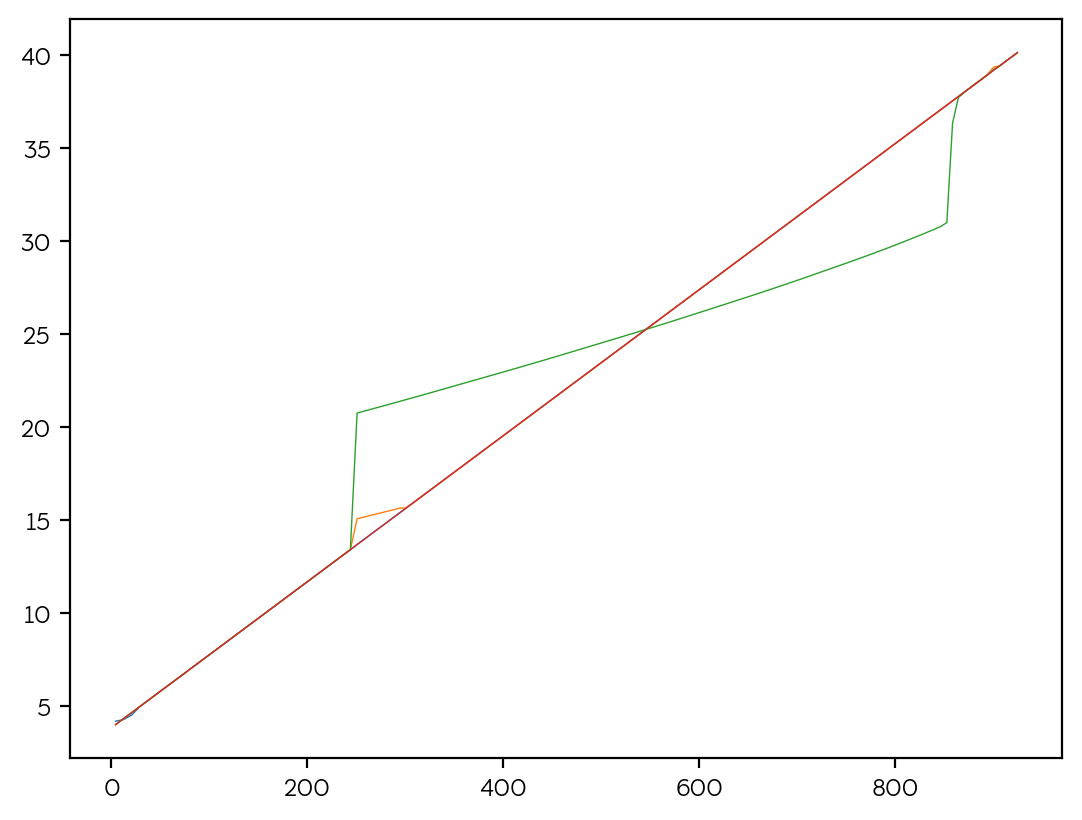

In [ ]:
plt.plot(olga_pure_co2_122.iloc[:, 0], olga_pure_co2_122.iloc[:, 7], lw=0.5)
plt.plot(olga_pure_co2_94.iloc[:, 0], olga_pure_co2_94.iloc[:, 7], lw=0.5)
plt.plot(olga_pure_co2_75.iloc[:, 0], olga_pure_co2_75.iloc[:, 7], lw=0.5)
plt.plot(olga_pure_co2_47.iloc[:, 0], olga_pure_co2_47.iloc[:, 7], lw=0.5)

In [14]:
olga_pure_co2_75

,Pipeline length [m],"HOL [-] (CHANNEL PACTH) ""Holdup (liquid volume fraction including solids)""",Pipeline length [m].1,"PT [bara] (CHANNEL PACTH) ""Pressure""",Pipeline length [m].2,"ROF [kg/m3] (CHANNEL PACTH) ""Fluid mixture density including all phases (also any solids, drilling fluids and deposits) in all layers.""",Pipeline length [m].3,"TM [C] (CHANNEL PACTH) ""Fluid temperature"""
0,4.133333,0.000000e+00,4.133333,33.528831,4.133333,87.640228,4.133333,4.000000
1,12.400000,0.000000e+00,12.400000,33.599892,12.400000,87.623428,12.400000,4.324586
2,20.666666,0.000000e+00,20.666666,33.670959,20.666666,87.635681,20.666666,4.649173
3,28.933332,0.000000e+00,28.933332,33.742008,28.933332,87.599068,28.933332,4.973759
4,37.200001,0.000000e+00,37.200001,33.813049,37.200001,87.591042,37.200001,5.298346
...,...,...,...,...,...,...,...,...
147,900.625000,2.220446e-16,900.625000,74.900139,900.625000,235.539597,900.625000,39.236439
148,906.625000,0.000000e+00,906.625000,75.038681,906.625000,235.230896,906.625000,39.436008
149,912.625000,0.000000e+00,912.625000,75.177063,912.625000,234.956802,912.625000,39.671558
150,918.625000,0.000000e+00,918.625000,75.315308,918.625000,234.796402,918.625000,39.907230


In [17]:
olga_pure_co2_94

,Pipeline length [m],"HOL [-] (CHANNEL PACTH) ""Holdup (liquid volume fraction including solids)""",Pipeline length [m].1,"PT [bara] (CHANNEL PACTH) ""Pressure""",Pipeline length [m].2,"ROF [kg/m3] (CHANNEL PACTH) ""Fluid mixture density including all phases (also any solids, drilling fluids and deposits) in all layers.""",Pipeline length [m].3,"TM [C] (CHANNEL PACTH) ""Fluid temperature"""
0,4.133333,0.0,4.133333,35.946838,4.133333,97.800659,4.133333,4.000000
1,12.400000,0.0,12.400000,36.026138,12.400000,97.767570,12.400000,4.324586
2,20.666666,0.0,20.666666,36.105419,20.666666,97.732582,20.666666,4.649173
3,28.933332,0.0,28.933332,36.184662,28.933332,97.697472,28.933332,4.973759
4,37.200001,0.0,37.200001,36.263870,37.200001,97.662231,37.200001,5.298346
...,...,...,...,...,...,...,...,...
147,900.625000,1.0,900.625000,94.100540,900.625000,591.750610,900.625000,39.372421
148,906.625000,1.0,906.625000,94.448624,906.625000,590.973694,906.625000,39.435719
149,912.625000,1.0,912.625000,94.795631,912.625000,588.153870,912.625000,39.671890
150,918.625000,1.0,918.625000,95.141006,918.625000,585.409790,918.625000,39.907478


In [18]:
olga_pure_co2_122.head(50)

,Pipeline length [m],"HOL [-] (CHANNEL PACTH) ""Holdup (liquid volume fraction including solids)""",Pipeline length [m].1,"PT [bara] (CHANNEL PACTH) ""Pressure""",Pipeline length [m].2,"ROF [kg/m3] (CHANNEL PACTH) ""Fluid mixture density including all phases (also any solids, drilling fluids and deposits) in all layers.""",Pipeline length [m].3,"TM [C] (CHANNEL PACTH) ""Fluid temperature"""
0,4.133333,8.066597e-04,4.133333,38.877979,4.133333,112.317596,4.133333,4.184672
1,12.400000,1.182885e-03,12.400000,38.968681,12.400000,112.938698,12.400000,4.276444
2,20.666666,2.673091e-06,20.666666,39.059551,20.666666,112.090698,20.666666,4.518456
3,28.933332,1.190479e-07,28.933332,39.150341,28.933332,111.835403,28.933332,4.967961
4,37.200001,1.602940e-10,37.200001,39.241009,37.200001,111.767303,37.200001,5.298322
5,45.466667,0.000000e+00,45.466667,39.331619,45.466667,111.699799,45.466667,5.622930
6,53.733334,0.000000e+00,53.733334,39.422180,53.733334,111.632103,53.733334,5.947517
7,62.000000,1.110223e-16,62.000000,39.512680,62.000000,111.564301,62.000000,6.272104
8,70.266670,0.000000e+00,70.266670,39.603142,70.266670,111.526802,70.266670,6.584061
9,78.533333,0.000000e+00,78.533333,39.693569,78.533333,111.491600,78.533333,6.921276


In [ ]:
sf_depth_msl = 312  # Water depth [meters]
sf_temp_degc = 4  # temperature at sea floor [degC]
field_fluid_type = "pure_co2"

p_models = {}
olga_dict = {}

delta_z_cases = dict()

for olga_case in olga_tables:
    geo_tgrad = 1e3 * ((olga_case.iloc[-1, 7] - 4.000000) / (924.812500 - 4.133333))

    z_eq = ((olga_case.iloc[-1, 7] - sf_temp_degc) / (geo_tgrad / 1e3)) + sf_depth_msl

    delta_z = z_eq - olga_case.iloc[-1, 0]

    CO2_contact = z_eq  # CO2 water contact mTVDMSL
    press = olga_case.iloc[-1, 3]
    press_label = f"{press:.2f}"

    delta_z_cases[press_label] = delta_z

    print(f"{geo_tgrad=} {sf_temp_degc=} {CO2_contact=} {field_fluid_type=} {press=}")

    olga_dict[press_label] = olga_case
    # '''Constants'''

    # geo_tgrad = 40 #geothermal gradient [degc/km]
    p_models[press_label] = Pressure(
        # wellbore seafloor depth mTVD MSL.
        sf_depth_msl=sf_depth_msl,  # wellbore.water_depth,
        # wellbore total depth in mTVD RKB
        well_td_rkb=5e3,  # total_depth_rkb,
        # wellbore rkb in mTVD RKB
        well_rkb=0,
        # seafloor temperature in degC
        sf_temp=sf_temp_degc,  # DEFAULT_SEAFLOOR_TEMPERATURE,
        # geothermal gradient in degC/km
        geo_tgrad=geo_tgrad,  # DEFAULT_GEOTHERMAL_GRADIENT,
        fluid_type=field_fluid_type,  # type: ignore
        # path to the pvt constants folder
        pvt_path=pvt_path,
        z_fluid_contact=CO2_contact,  # wellbore_settings.pressure_datum_tvd_msl,  # type: ignore
        p_fluid_contact=press,  # wellbore_settings.reservoir_pressure_bar,  # type: ignore
        # specific_gravity=None,  # type: ignore
        # ip_shmin_data=shmin_data,
        shmin_gradient=0.3,
    )

geo_tgrad=np.float64(39.26466790918936) sf_temp_degc=4 CO2_contact=np.float64(1232.679167) field_fluid_type='pure_co2' press=np.float64(123.02449798584)
Computing pressure profile for scenario: hydrostatic
geo_tgrad=np.float64(39.26493722702677) sf_temp_degc=4 CO2_contact=np.float64(1232.679167) field_fluid_type='pure_co2' press=np.float64(95.4954299926758)
Computing pressure profile for scenario: hydrostatic
geo_tgrad=np.float64(39.26460161556778) sf_temp_degc=4 CO2_contact=np.float64(1232.679167) field_fluid_type='pure_co2' press=np.float64(75.4576873779297)
Computing pressure profile for scenario: hydrostatic
geo_tgrad=np.float64(39.264493888432796) sf_temp_degc=4 CO2_contact=np.float64(1232.679167) field_fluid_type='pure_co2' press=np.float64(47.751220703125)
Computing pressure profile for scenario: hydrostatic


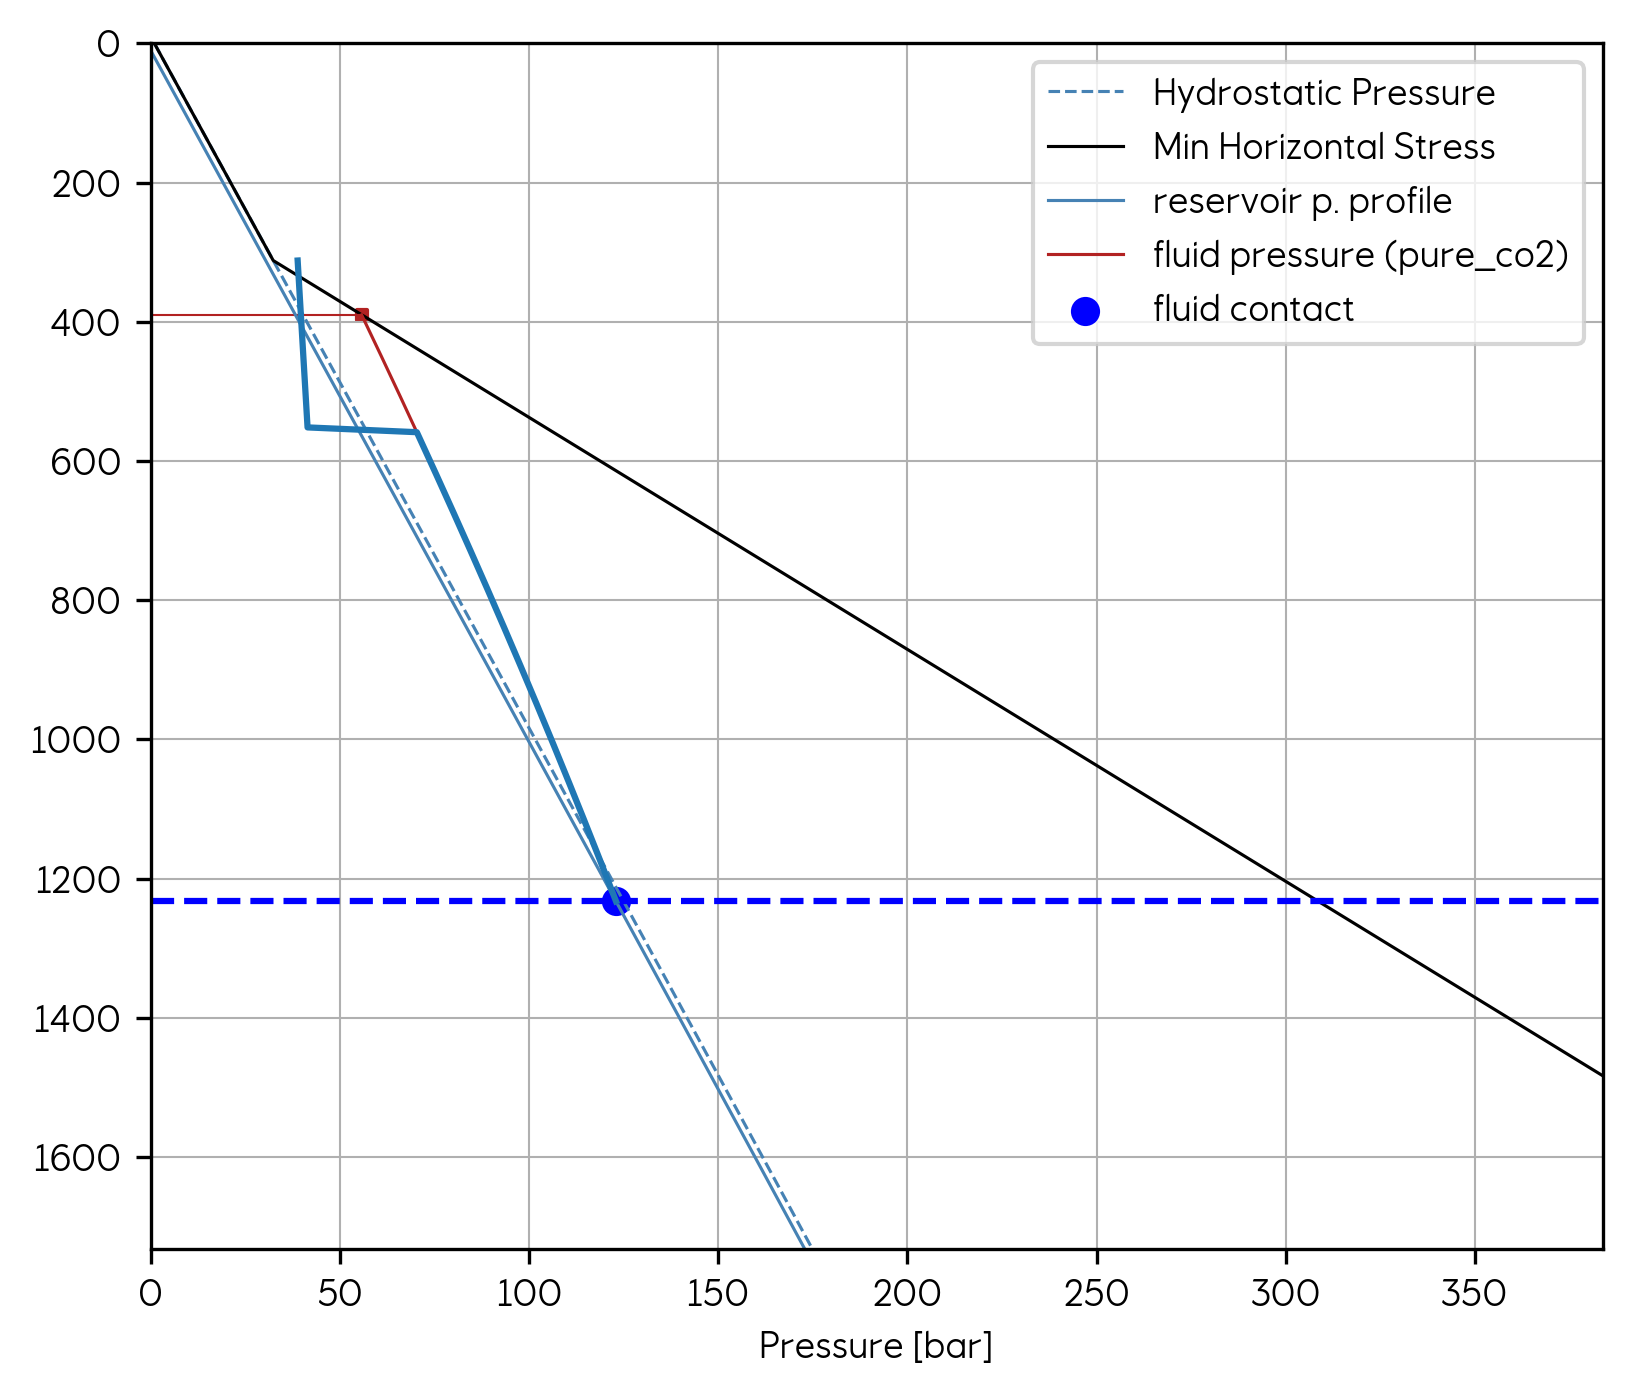

In [ ]:
rcParams["figure.dpi"] = 300

width_cm = 14  # cm
height_cm = 12  # cm

width = width_cm / 2.54
height = height_cm / 2.54

fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = "123.02"

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], delta_z + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

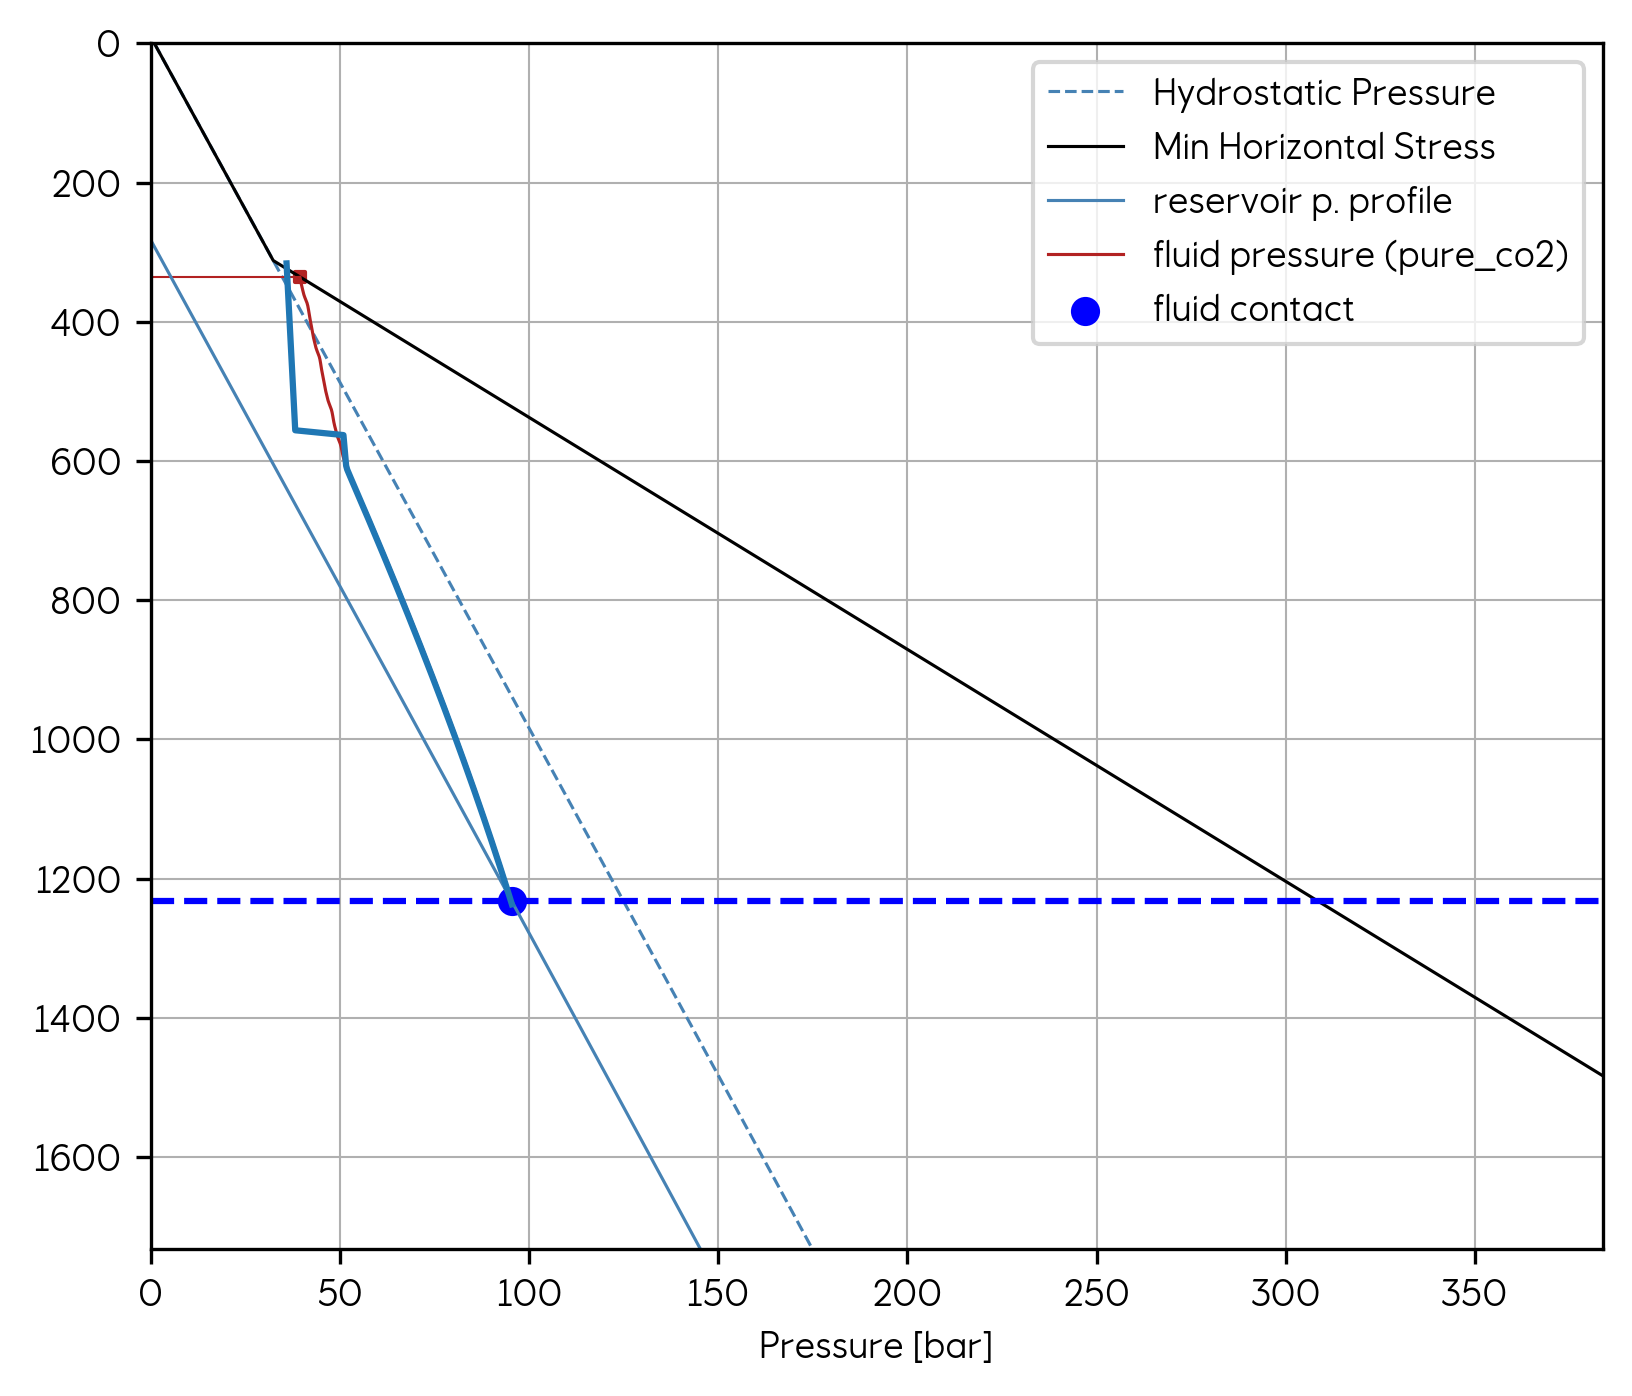

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(p_models.keys())[1]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], sf_depth_msl + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

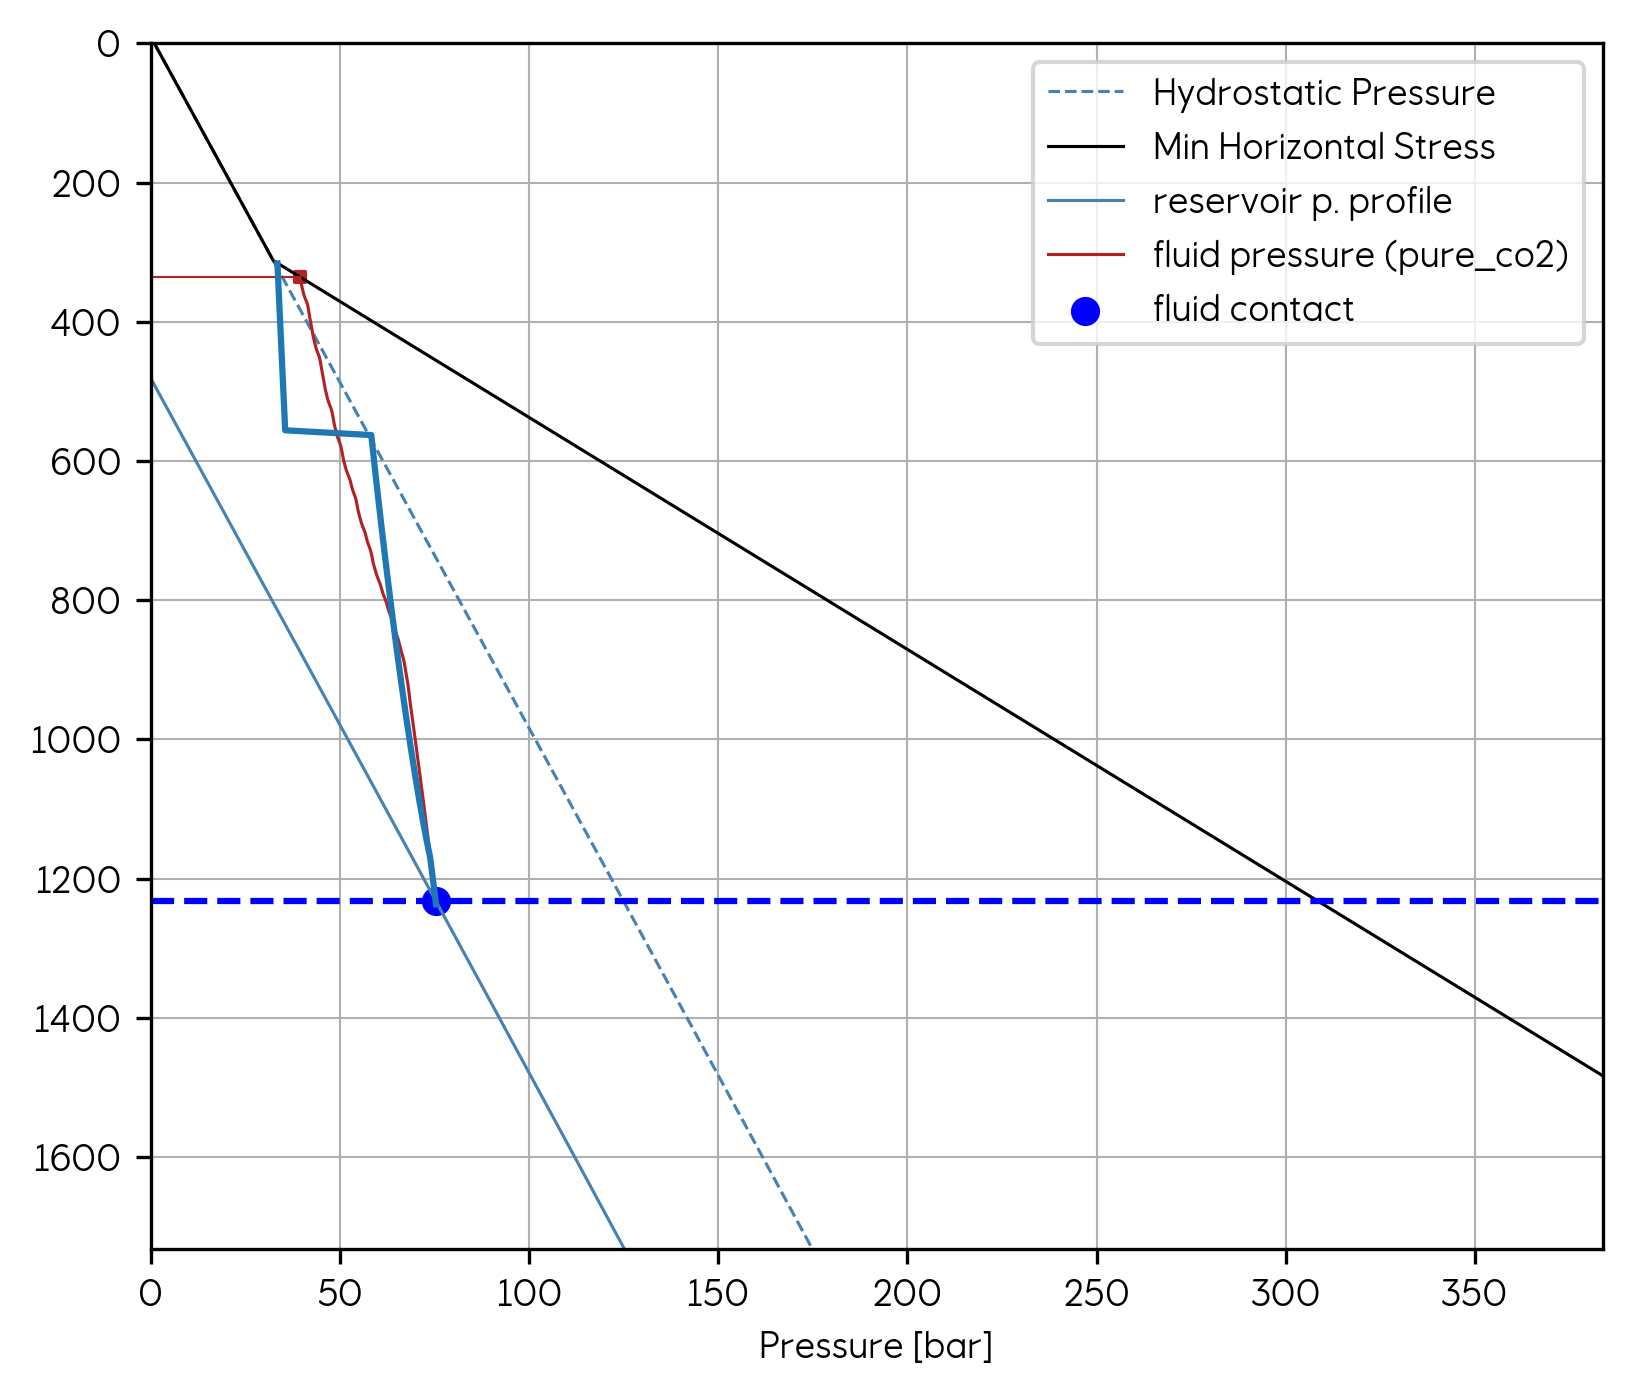

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(p_models.keys())[2]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], sf_depth_msl + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

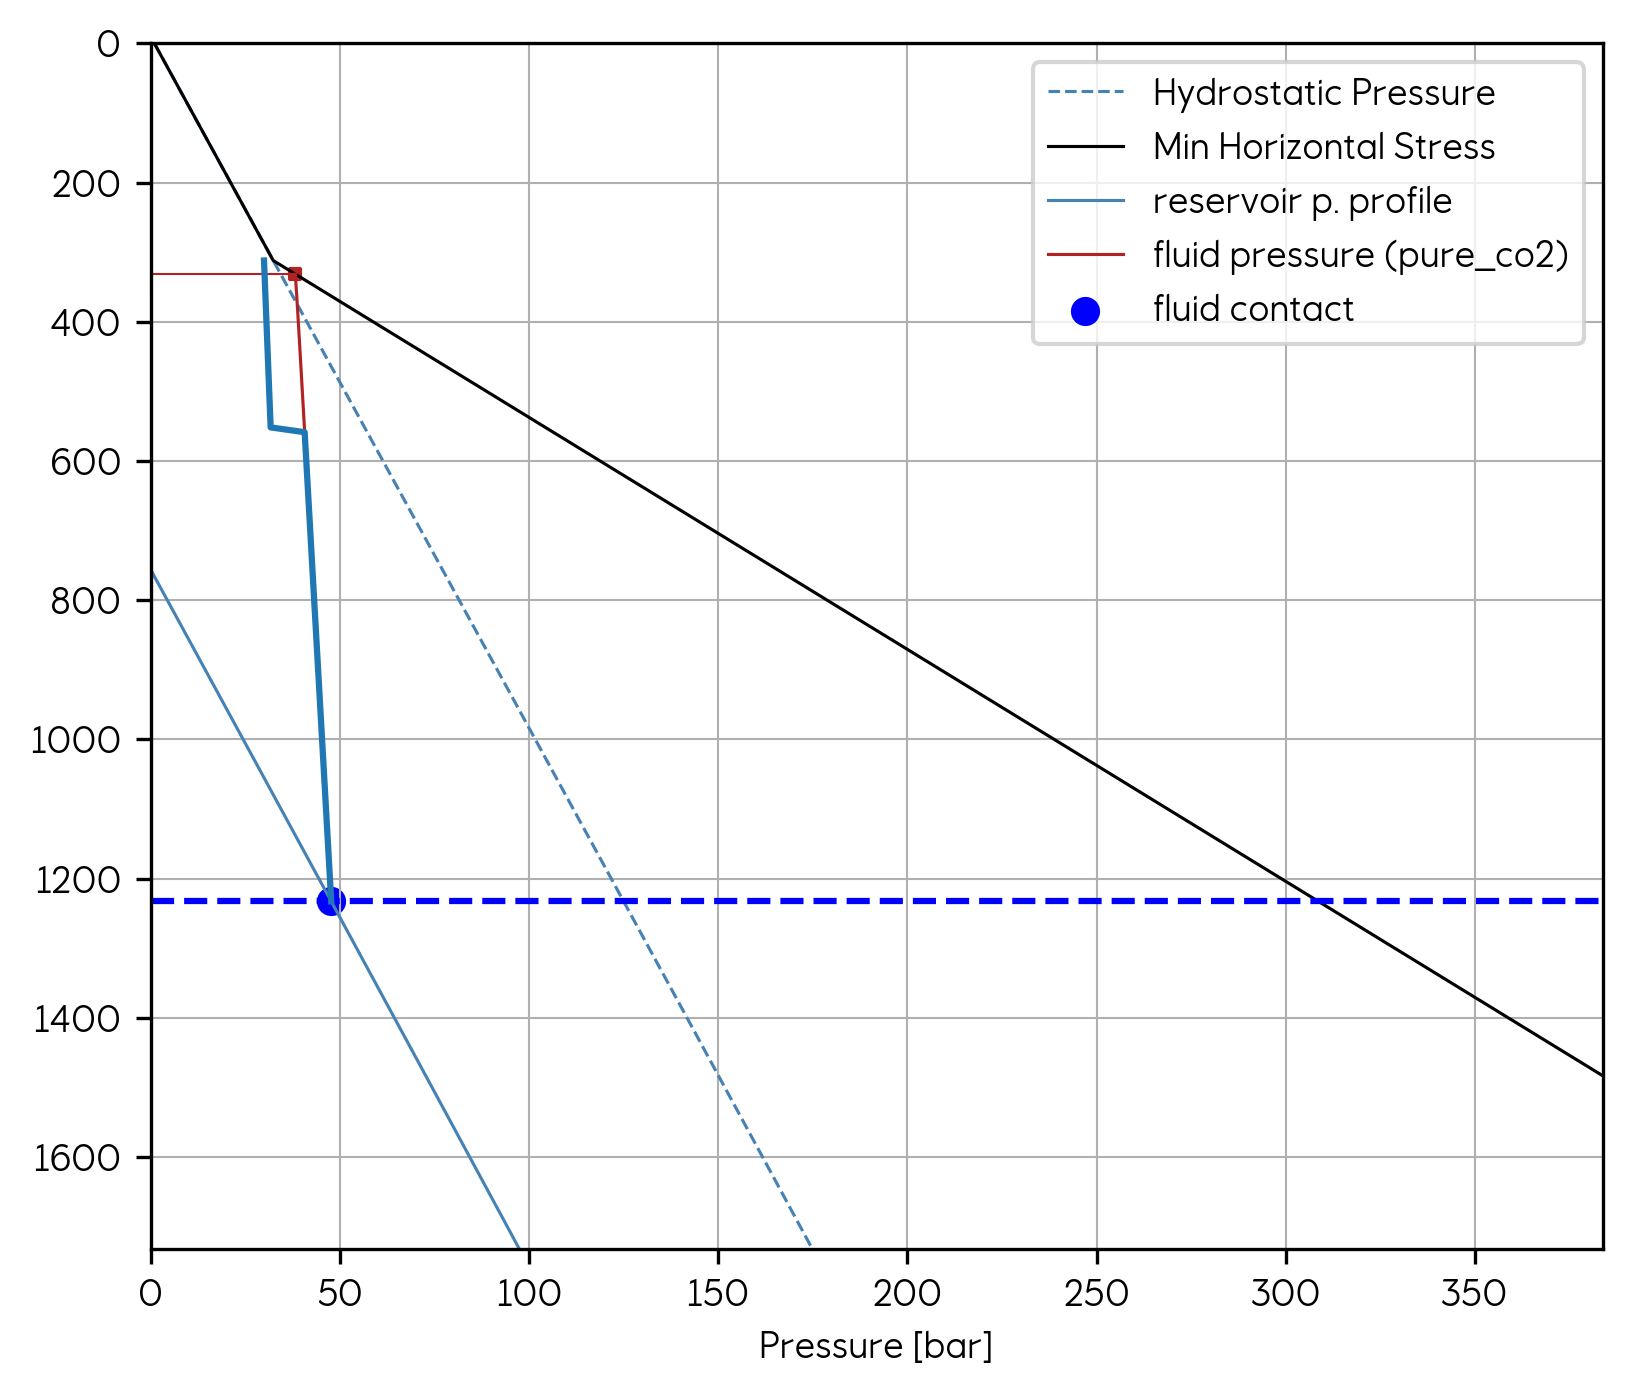

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(p_models.keys())[3]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], delta_z + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

In [25]:
13.98 / (const.inch * 100)

5.503937007874016

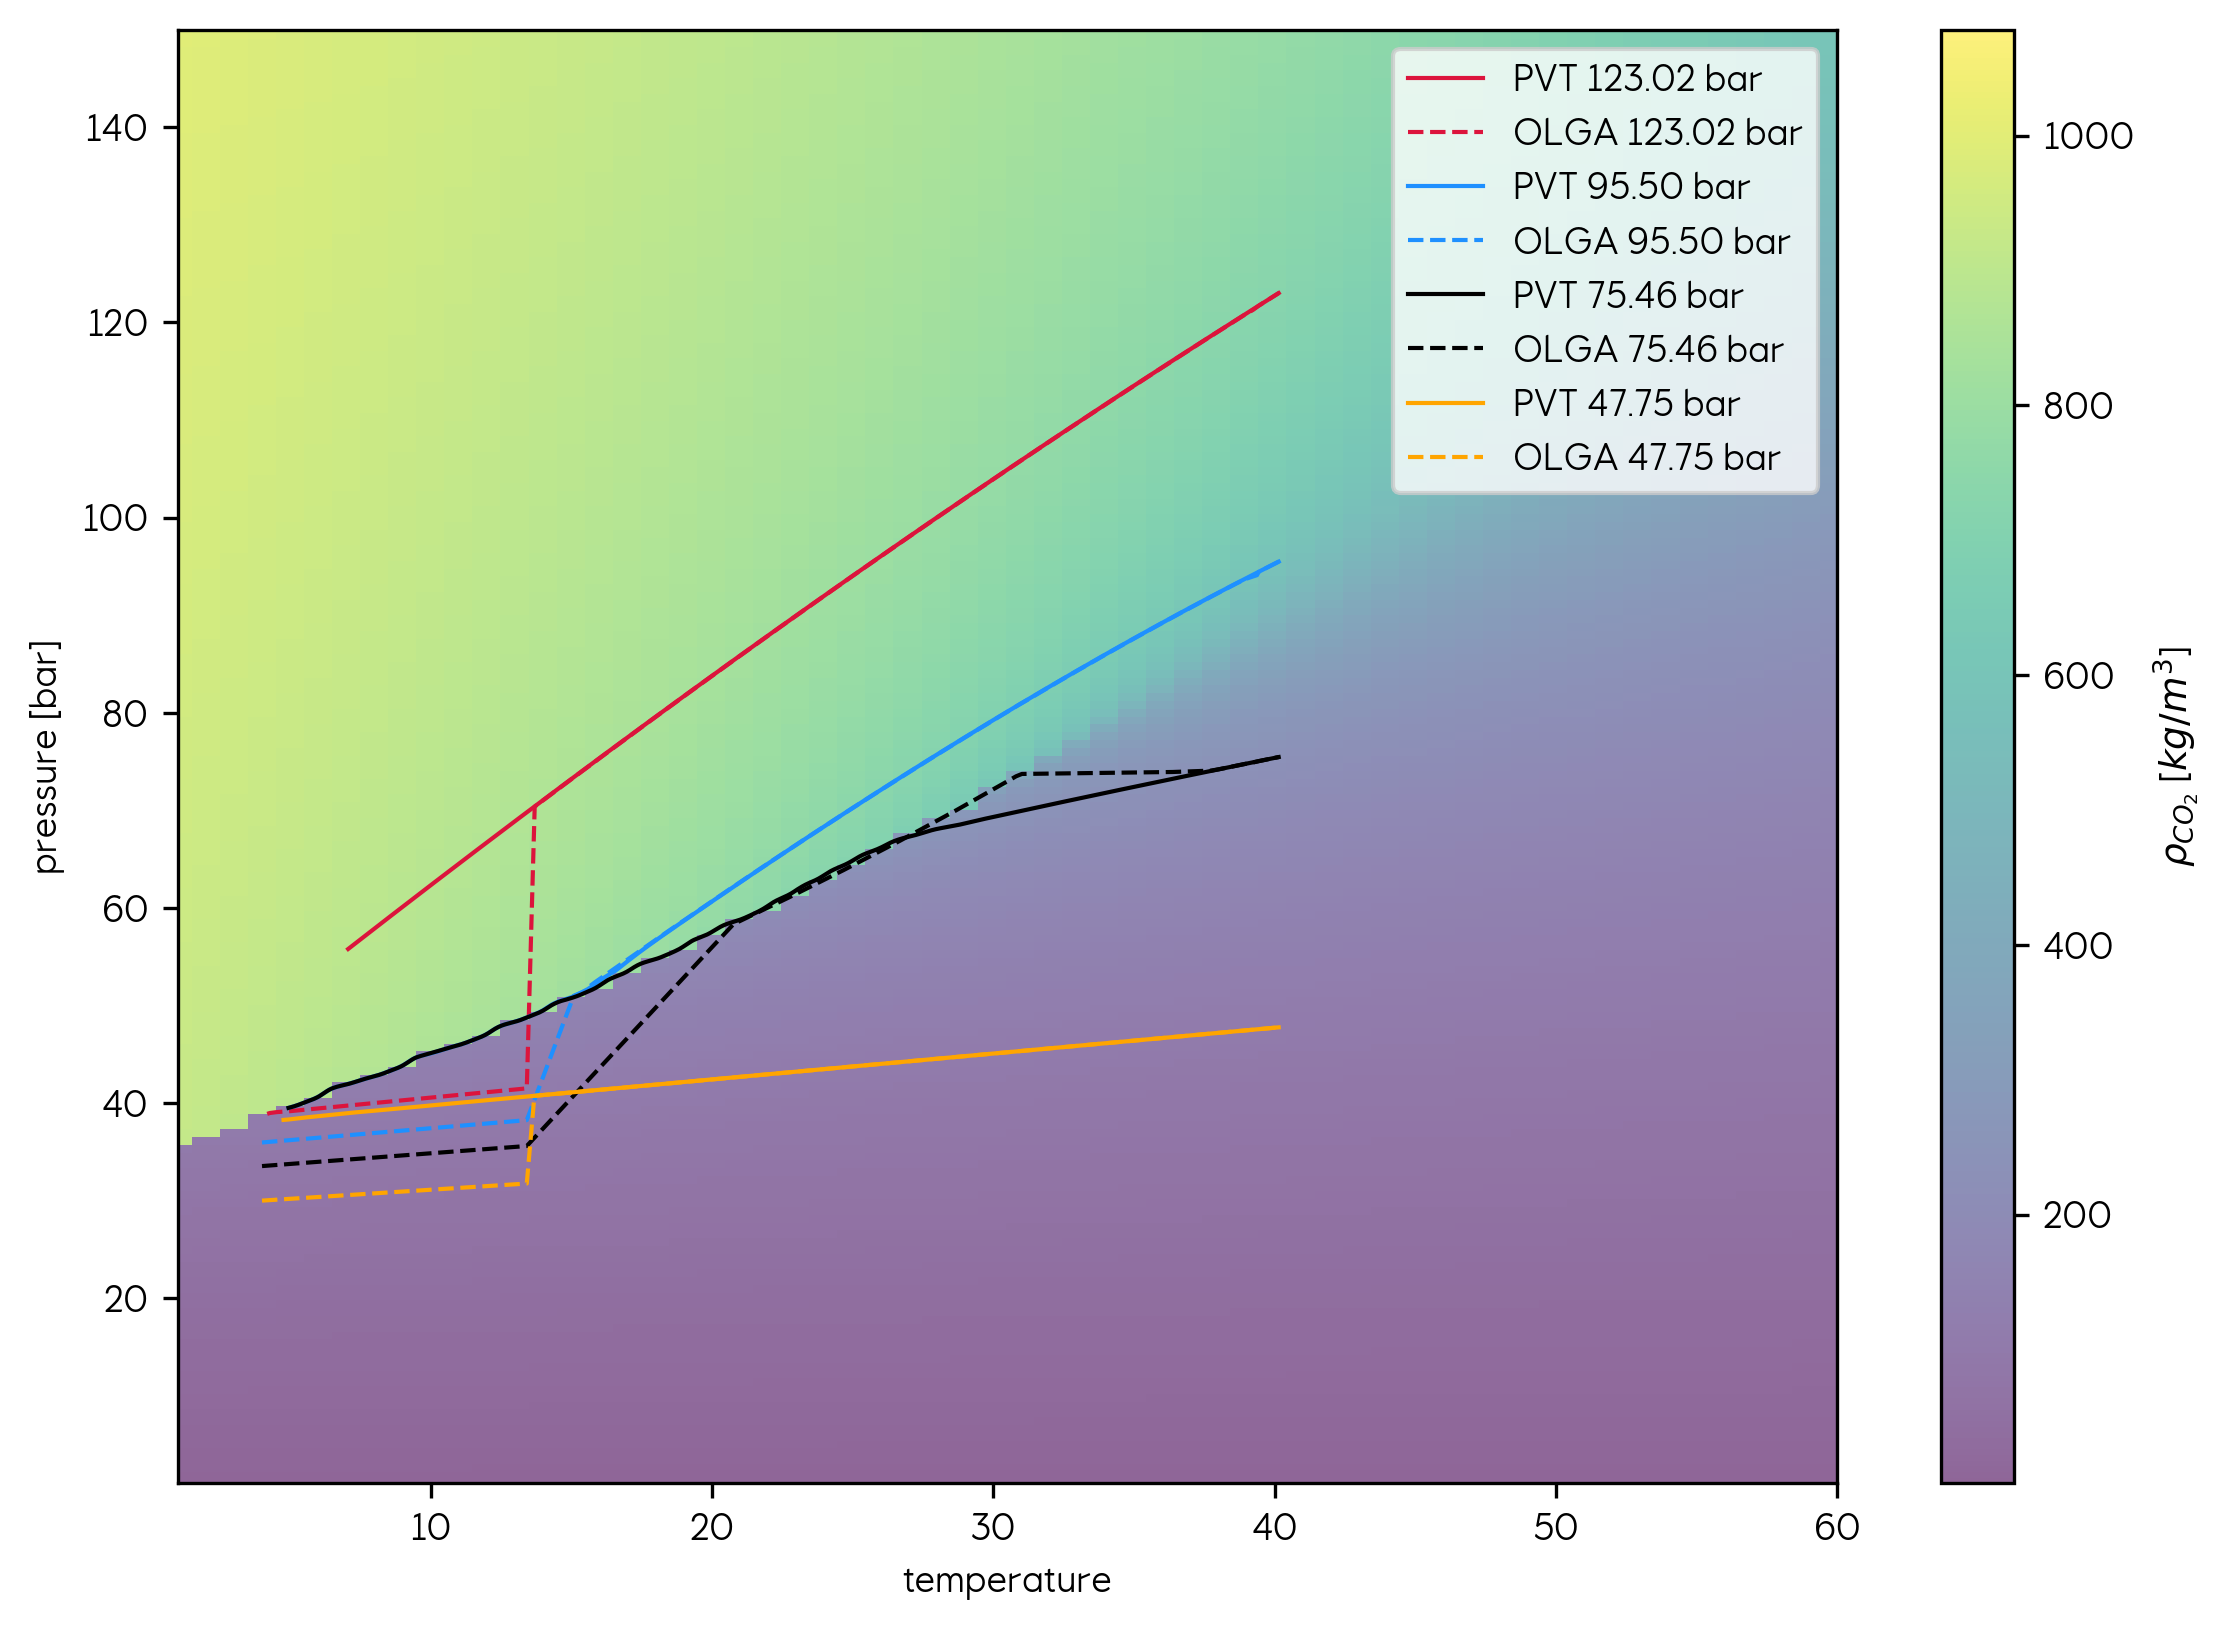

In [ ]:
# Plot tables
from itertools import cycle

height = 13.98 / (const.inch * 100)
width = 19.5 / (const.inch * 100)

fig, ax = plt.subplots(1, 1, figsize=(width, height))
# Plot density colormap
rho_pcm_co2 = ax.pcolormesh(co2_pvt_data["temperature"], co2_pvt_data["pressure"], co2_pvt_data["pure_co2"]["rho"], alpha=0.6)

ax.set_xlabel("temperature [degC]")
ax.set_ylabel("pressure [bar]")

color_cycle = cycle(["#DC143C", "#1E90FF", "k", "#FFA500"])


# ax.plot(olga_pure_co2_122.iloc[:,7], olga_pure_co2_122.iloc[:,3], color=next(color_cycle))
# ax.plot(olga_pure_co2_94.iloc[:,7], olga_pure_co2_94.iloc[:,3], color=next(color_cycle))
# ax.plot(olga_pure_co2_75.iloc[:,7], olga_pure_co2_75.iloc[:,3], color=next(color_cycle))
# ax.plot(olga_pure_co2_47.iloc[:,7], olga_pure_co2_47.iloc[:,3], color=next(color_cycle))

for scenario, color in zip(p_models, color_cycle):
    p_models[scenario].scenario_manager.scenarios["hydrostatic"].init_curves.plot(
        "temperature", "fluid_pressure", ax=ax, color=color, label=f"PVT {scenario} bar", lw=1
    )

    ax.plot(olga_dict[scenario].iloc[:, 7], olga_dict[scenario].iloc[:, 3], color=color, ls="--", label=f"OLGA {scenario} bar", lw=1)

ax.set_xlim(1, 60)

ax.set_ylim(1, 150)
ax.legend()

fig.colorbar(rho_pcm_co2, label=r"$\rho_{CO_2}$ [$kg/m^3$]")


fig.tight_layout()

In [ ]:
scenario = "95.50"
df = p_models[scenario].scenario_manager.scenarios["hydrostatic"].init_curves

df[~df["fluid_pressure"].isna()]

,depth,temperature,hydrostatic_pressure,min_horizontal_stress,fluid_pressure,brine_pressure
336.000000,336.000000,4.942358,34.843219,39.625442,39.495647,5.428068
337.000000,337.000000,4.981623,34.943961,39.925442,39.526139,5.528674
338.000000,338.000000,5.020888,35.044704,40.225442,39.557211,5.629281
339.000000,339.000000,5.060153,35.145447,40.525442,39.589033,5.729887
340.000000,340.000000,5.099418,35.246190,40.825442,39.621776,5.830493
...,...,...,...,...,...,...
1229.000000,1229.000000,40.005947,124.664362,307.525442,95.285243,95.127189
1230.000000,1230.000000,40.045212,124.764579,307.825442,95.342433,95.227279
1231.000000,1231.000000,40.084477,124.864795,308.125442,95.399577,95.327367
1232.000000,1232.000000,40.123742,124.965010,308.425442,95.456676,95.427455


In [ ]:
olga_dict[scenario]["depth"] = olga_dict[scenario].iloc[:, 0] + sf_depth_msl
olga_dict[scenario]

,Pipeline length [m],"HOL [-] (CHANNEL PACTH) ""Holdup (liquid volume fraction including solids)""",Pipeline length [m].1,"PT [bara] (CHANNEL PACTH) ""Pressure""",Pipeline length [m].2,"ROF [kg/m3] (CHANNEL PACTH) ""Fluid mixture density including all phases (also any solids, drilling fluids and deposits) in all layers.""",Pipeline length [m].3,"TM [C] (CHANNEL PACTH) ""Fluid temperature""",depth
0,4.133333,0.0,4.133333,35.946838,4.133333,97.800659,4.133333,4.000000,316.133333
1,12.400000,0.0,12.400000,36.026138,12.400000,97.767570,12.400000,4.324586,324.400000
2,20.666666,0.0,20.666666,36.105419,20.666666,97.732582,20.666666,4.649173,332.666666
3,28.933332,0.0,28.933332,36.184662,28.933332,97.697472,28.933332,4.973759,340.933332
4,37.200001,0.0,37.200001,36.263870,37.200001,97.662231,37.200001,5.298346,349.200001
...,...,...,...,...,...,...,...,...,...
147,900.625000,1.0,900.625000,94.100540,900.625000,591.750610,900.625000,39.372421,1212.625000
148,906.625000,1.0,906.625000,94.448624,906.625000,590.973694,906.625000,39.435719,1218.625000
149,912.625000,1.0,912.625000,94.795631,912.625000,588.153870,912.625000,39.671890,1224.625000
150,918.625000,1.0,918.625000,95.141006,918.625000,585.409790,918.625000,39.907478,1230.625000
